In [1]:
from typing import Tuple, Optional
from data.hysteresis import hysteresis_ode, simulate_steady_state
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from scipy.integrate import solve_ivp
from stabnode.data import TrajectoryDataset
from stabnode.node import StabNODE, Felu, Gelu
from stabnode.utils import _load_loop_wrapper, set_global_seed
from scipy.interpolate import interp1d

# from torchdiffeq import odeint
import torchode 
from torchode import solve_ivp
import time
import random

seed=1
set_global_seed(seed)


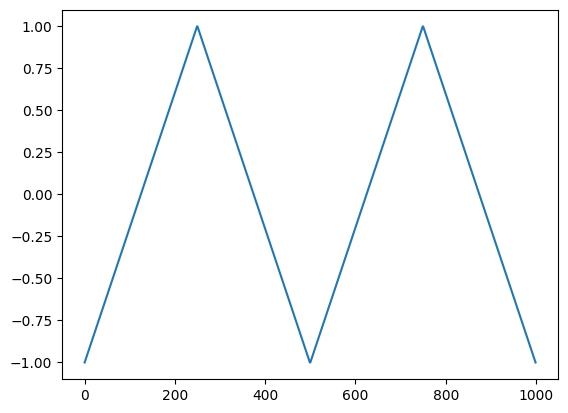

In [2]:
lam_start = -1 
lam_end = 1

n_points = 250

lam_increase = np.linspace(lam_start,lam_end, n_points)
lam_decrease = np.linspace(lam_end, lam_start, n_points)

lam_np = np.hstack((lam_increase,lam_decrease))
repeat = 1
for _ in range(repeat):
    lam_np = np.hstack((lam_np, lam_np))
plt.plot(lam_np)
plt.show()

In [3]:
end = 50
t_eval = np.linspace(0,end,101)
x0s = np.linspace(-1.6,-1.,5)
Xs = []
for x0 in tqdm(x0s):
    X, lam, t = simulate_steady_state(lam_np, x0=x0,t_span=[0,end], t_eval=t_eval,show_progress=False)
    Xs.append(X)
Xs = torch.cat(Xs,dim=0)

  0%|          | 0/5 [00:00<?, ?it/s]

In [4]:
Xs.shape # [dim, n_samples]

torch.Size([5, 100001])

In [5]:
scaler = MinMaxScaler(feature_range=(-1,1))
scaler = StandardScaler()
scaler.fit(Xs.T)
X_scaled = scaler.transform(Xs.T).T
X_scaled = torch.tensor(X_scaled, dtype=torch.float32, device='cpu')

In [6]:
x0s

array([-1.6 , -1.45, -1.3 , -1.15, -1.  ])

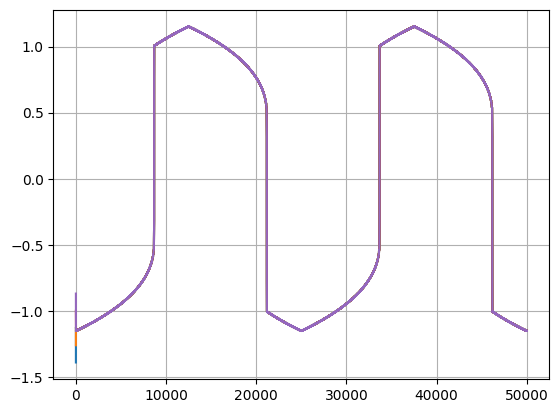

In [7]:
cutoff = -1
X_scaled.shape # [dim, samples]
for xi in X_scaled:
    # print(xi.shape)
    plt.plot(t[:cutoff],xi[:cutoff])
plt.grid(True)
plt.savefig('standardscalar_traj.png')
plt.show()

In [8]:
sample_rate=10
train_idx = torch.arange(0,len(t),sample_rate)
train_idx
X_train = X_scaled[:,train_idx]
t_train = t[train_idx]
lam_train = lam[train_idx]
X_train.shape, X_scaled.shape

(torch.Size([5, 10001]), torch.Size([5, 100001]))

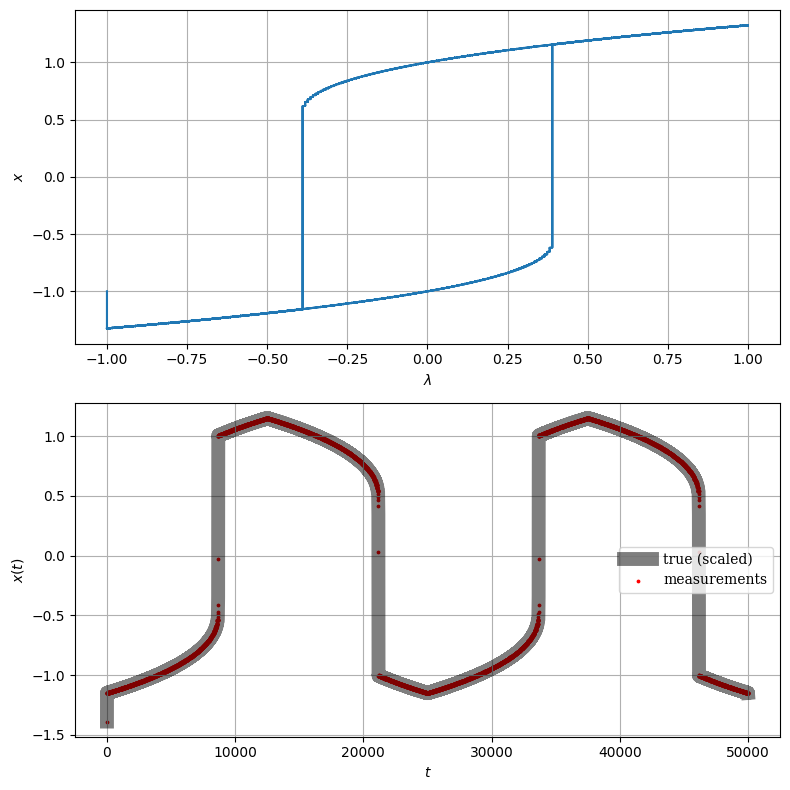

In [9]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,8))
ax1.plot(lam, X[0,:])
ax1.set_xlabel(r"$\lambda$")
ax1.set_ylabel(r"$x$")
ax1.grid(True)

ax2.plot(t, X_scaled[0,:], lw=10,c='black', alpha=0.5, label="true (scaled)")
ax2.scatter(t_train, X_train[0,:],c='red',s=3, label="measurements")
ax2.set_xlabel(r"$t$")
ax2.set_ylabel(r"$x(t)$")
ax2.grid(True)
ax2.legend(prop={'family':'serif'})
plt.tight_layout()
plt.show()

In [10]:
window_size = 501
window_size = None
train_dataset = TrajectoryDataset(X_train.T, t_train, window_size=window_size)
len(train_dataset)

1

In [11]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1,shuffle=True, num_workers=0)
len(train_loader)

1

In [12]:
f = Felu(len(x0s),1,4)
g = Gelu(len(x0s)+1,1,2)
model = StabNODE(f,g).to('cpu')
model

StabNODE(
  (f): Felu(
    (network): Sequential(
      (0): Linear(in_features=5, out_features=4, bias=True)
      (1): ELU(alpha=1.0)
      (2): Linear(in_features=4, out_features=1, bias=True)
    )
  )
  (g): Gelu(
    (network): Sequential(
      (0): Linear(in_features=6, out_features=2, bias=True)
      (1): ELU(alpha=1.0)
      (2): Linear(in_features=2, out_features=1, bias=True)
      (3): Tanh()
    )
  )
)

In [13]:
interp_lam = interp1d(t.numpy(), lam.numpy(), axis=0, kind='linear')

def control_func(t: torch.Tensor):
    t_scalar = t.item()
    lam_t = torch.tensor(interp_lam(t_scalar), dtype=torch.float32)
    return lam_t.unsqueeze(0)

def control_func(t: torch.Tensor) -> torch.Tensor:
    """
    t: Tensor of shape [B] or scalar
    Returns: Tensor of shape [B, 1]
    """
    if t.dim() == 0:  # scalar time
        t_scalar = t.item()
        lam_t = torch.tensor(interp_lam(t_scalar), dtype=torch.float32)
        return lam_t.unsqueeze(0)
    else:  # batched time
        lam_t = interp_lam(t.detach().cpu().numpy())  # shape [B,]
        lam_t = torch.tensor(lam_t, dtype=torch.float32).unsqueeze(1)  # shape [B, 1]
        return lam_t.to(t.device)

### Write new model trainer with  `torchode.solve_ivp`

In [14]:
n_epochs = 10
lr = 1e-2
show_progress = True
solve_method = 'dopri5'
solve_method = 'tsit5'
loss_criteria = nn.MSELoss()
opt = torch.optim.Adam(list(f.parameters())+list(g.parameters()), lr = lr)


loop_wrapper = _load_loop_wrapper(show_progress)
loop_wrapper2 = _load_loop_wrapper(True)

model.train()
losses = []
times = []

Xi_epoch_predictions = []
Tis_epoch = []
for epoch in loop_wrapper(range(n_epochs)):
    t1 = time.time()
    epoch_loss = 0.0
    num_batches = 0
    epoch_losses = []

    Xi_predictions = []
    Tis = []
    for Xi, Ti, x0i in loop_wrapper2(train_loader):
        Xi = Xi.squeeze() # [batch, time, dim]
        Ti = Ti.squeeze()

        if not x0i.requires_grad:
            x0i = x0i.clone().detach().requires_grad_()


        opt.zero_grad()

        sol = solve_ivp(
            f=lambda t, x: model(t, x, control_func),
            y0=x0i,
            t_eval=Ti,
            method=solve_method
        )

        Xi_pred = sol.ys.squeeze()
        Xi_predictions.append(Xi_pred)
        Tis.append(Ti)
        loss = loss_criteria(Xi_pred, Xi)

        loss.backward()
        opt.step()
        epoch_losses.append(loss.item())
        epoch_loss += loss.item()
        num_batches += 1

    Xi_epoch_predictions.append(Xi_predictions)
    Tis_epoch.append(Tis)
    avg_loss = epoch_loss / num_batches
    losses.append(avg_loss)

    t2 = time.time()
    times.append(t2 - t1)

    # if avg_loss < 0.01:
    #     break

    

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
# for test_Xi_pred in Xi_predictions:
#     test = test_Xi_pred.detach().numpy()
#     blowup_idx = np.where(np.isnan(test))[0]
#     print(blowup_idx)
#     print(test[blowup_idx])
#     print()

In [ ]:
# fig, ax = plt.subplots(1,1, figsize = (10,5))

# ax.plot(t, X_scaled[0,:], lw=10,c='black', alpha=0.4, label="true (scaled)")
# ax.scatter(t_train, X_train[0,:],c='red',s=3, label="measurements")
# ax.set_xlabel(r"$t$")
# ax.set_ylabel(r"$x(t)$")
# ax.set_ylim(-1.1,1.1)
# ax.grid(True)

# for idx in range(len(Tis)):
#     ax.plot(Tis[idx], Xi_predictions[idx].detach().numpy(), linestyle='--')
# ax.legend()
# ax.set_title(f"Epoch 1, sample size {len(X_train.T)}/ {len(X_scaled.T)}")

# plt.suptitle(r"Simple Hystersis Training: torchode", family='serif',size=20)
# plt.savefig(f"torchode_training_epochs_{n_epochs}_batches_{len(train_loader)}_sover_{solve_method}.png")
# plt.show()

In [ ]:
for yes in X_scaled:
    llkjs = yes

llkjs.shape
X_train.shape, X_scaled.shape

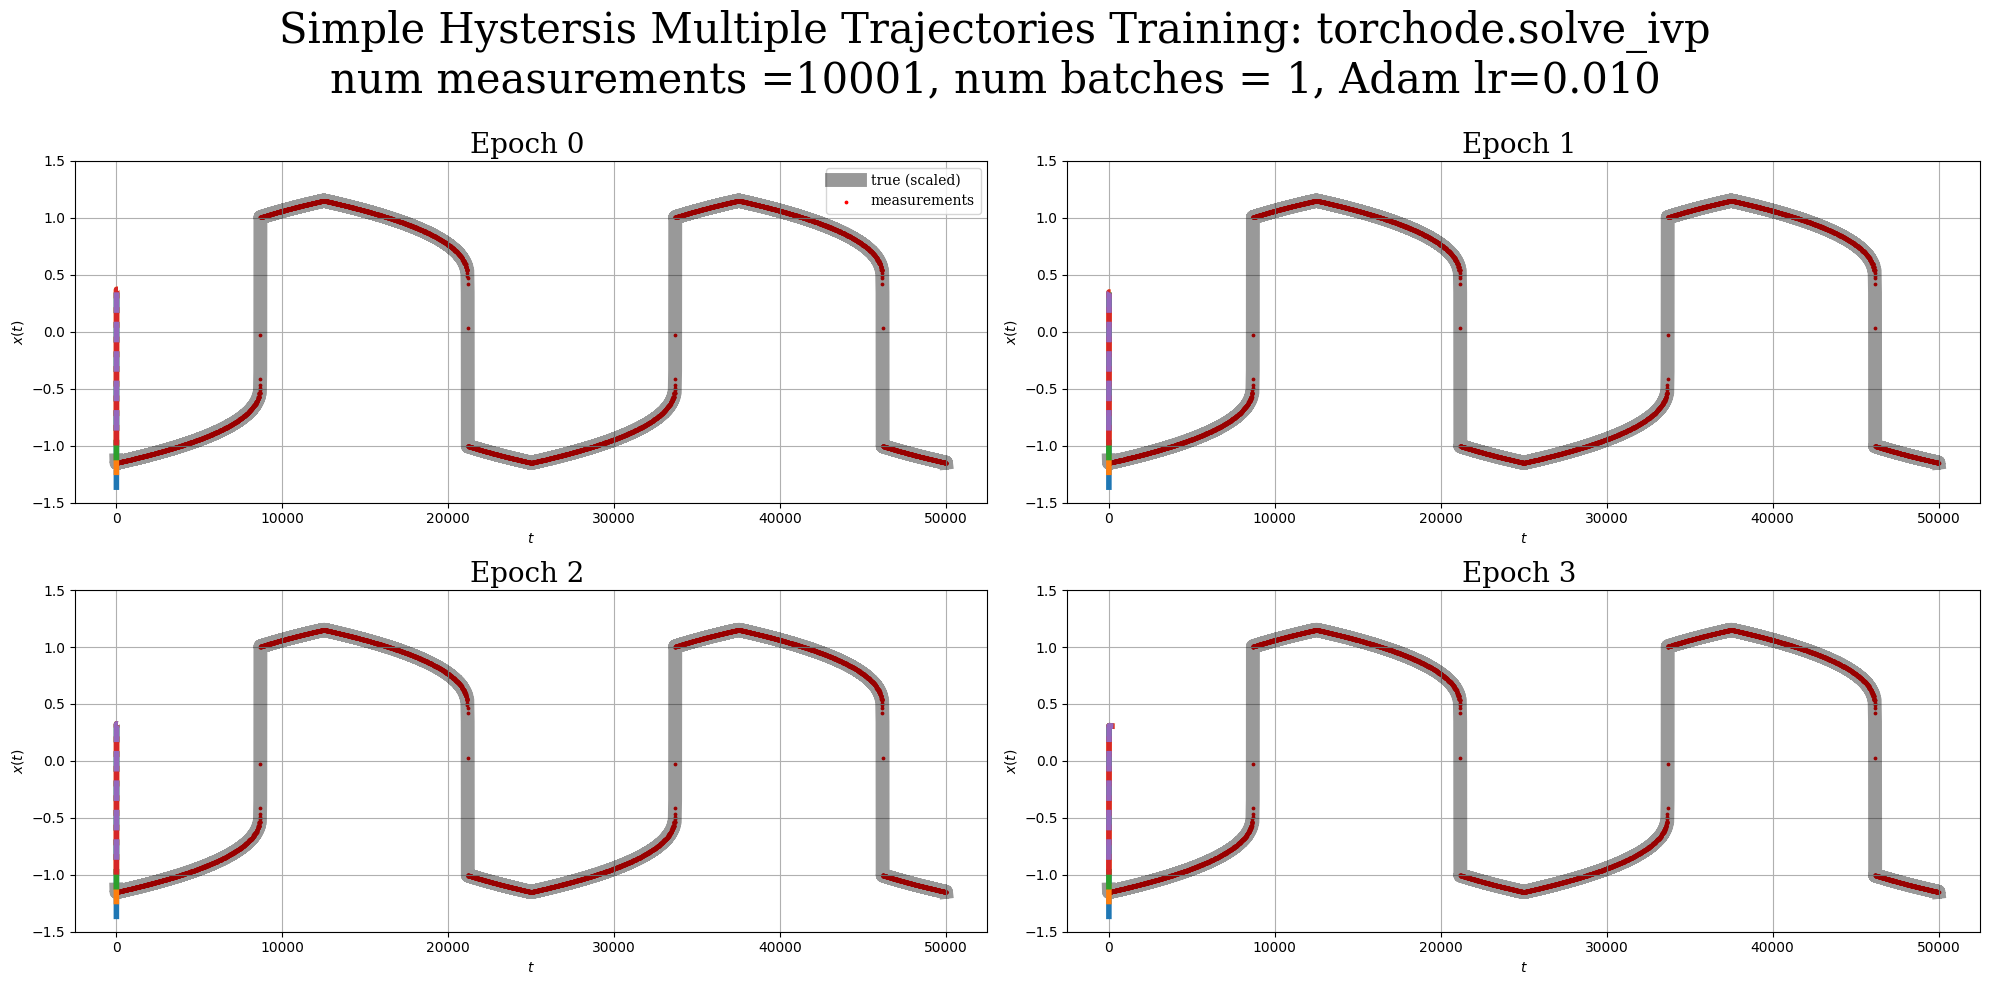

In [16]:
fig, axs = plt.subplots(2,2,figsize=(20,3*len(Xi_epoch_predictions)//3))
word = 2
batch_cuttoff = 10
axs = axs.flatten()
for idx,ax in enumerate(axs):
    
    ax.plot(t, X_scaled[word,:], lw=10,c='black', alpha=0.4, label="true (scaled)")
    ax.scatter(t_train, X_train[word,:],c='red',s=3, label="measurements")
    ax.set_xlabel(r"$t$")
    ax.set_ylabel(r"$x(t)$")
    ax.set_ylim(-1.5,1.5)
    ax.grid(True)
    ax.set_title(f"Epoch {idx} ", family='serif',size=20)

    Xi_epoch_i = Xi_epoch_predictions[idx]
    Tis_epoch_i = Tis_epoch[idx]

    if len(Xi_epoch_i) >1:
        batch_cuttoff = np.min((batch_cuttoff, len(Xi_epoch_i)))
        Xi_epoch_i = Xi_epoch_i[:batch_cuttoff]
        Tis_epoch_i=Tis_epoch[idx][:batch_cuttoff]

    for xi, ti in zip(Xi_epoch_i, Tis_epoch_i):
        for xii in xi.T:
            ax.plot(ti, xii.detach().numpy(),linestyle='--',lw=4)
    
    if idx ==0:
        ax.legend(prop={'family':'serif'})

plt.suptitle(f"Simple Hystersis Multiple Trajectories Training: torchode.solve_ivp\nnum measurements ={len(X_train.T)}, num batches = {len(train_loader)}, Adam lr={lr:.3f}", family='serif',size=30)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.savefig(f"torchode_multi_traj_training_epochs_{n_epochs}_batches_{len(train_loader)}_sover_{solve_method}_seed_{seed}_lr_{lr}_standard_scalar.png")
plt.show()

In [ ]:
for out in train_loader:
    Xi, ti, x0i = out
    print(Xi.shape,ti.shape, x0i.shape)

In [ ]:
control_func(ti[0,0]).shape

In [ ]:
for idx,(Xi, ti, x0) in enumerate(train_loader):
    plt.title(f"plot {idx}")
    plt.plot(ti.squeeze(), Xi.squeeze())
    plt.show()
    print(f"{idx}: {ti.squeeze()[:10]}")

In [ ]:
solve_method = 'dopri5'
for Xi, Ti, x0i in train_loader:
    sol = solve_ivp(
        f=lambda t, x: model(t, x, control_func),
        y0=x0i,
        t_eval=Ti.squeeze(0),
        method=solve_method
    )

In [ ]:
sol.ys.shape,Xi.shape

In [ ]:
for xxx, ttt, si in zip(Xi.squeeze().T, Ti.squeeze(),sol.ys.squeeze().T):
    plt.plot(xxx.detach().numpy())
    plt.plot(si.detach().numpy())
plt.show()


In [ ]:
for out in train_loader:
    Xi, ti, x0 = out

In [ ]:
Xi.shape

In [ ]:
sol.ys[0,:10,0]

In [ ]:
sol.ys.requires_grad

In [ ]:
x0i.grad

In [ ]:
sol.message

In [ ]:
Ti.shape

In [ ]:
xii